In [ ]:
# https://archive.ics.uci.edu/dataset/572/taiwanese+bankruptcy+prediction

In [ ]:
!pip install optuna xgboost catboost

from pprint import pprint
import warnings
import logging

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_validate
from collections import Counter

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import KFold

import optuna

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from plotly.io import show

pd.set_option('future.no_silent_downcasting', True) # pd.replace throws warning
warnings.filterwarnings('ignore') # silence complex warning in minisom
logging.getLogger("lightgbm").setLevel(logging.ERROR)
optuna.logging.set_verbosity(optuna.logging.WARNING) # silence outputs

plt.style.use('ggplot') # nice colorscheme

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.0 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
df = pd.read_csv(f'https://drive.google.com/uc?id=1qhlzqqlgcdEE55rMksnIJzkxj8D9OufM')

In [ ]:
pprint(df.columns)

Index(['Bankrupt?', ' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' Operating Gross Margin', ' Realized Sales Gross Margin',
       ' Operating Profit Rate', ' Pre-tax net Interest Rate',
       ' After-tax net Interest Rate',
       ' Non-industry income and expenditure/revenue',
       ' Continuous interest rate (after tax)', ' Operating Expense Rate',
       ' Research and development expense rate', ' Cash flow rate',
       ' Interest-bearing debt interest rate', ' Tax rate (A)',
       ' Net Value Per Share (B)', ' Net Value Per Share (A)',
       ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons',
       ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)',
       ' Operating Profit Per Share (Yuan ¥)',
       ' Per Share Net profit before tax (Yuan ¥)',
       ' Realized Sales Gross Profit Growth Rate',
       ' Operating Profit

In [ ]:
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [ ]:
df.shape

(6819, 96)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [ ]:
df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


In [ ]:
df['Bankrupt?'].value_counts()

,count
Bankrupt?,
0,6599
1,220


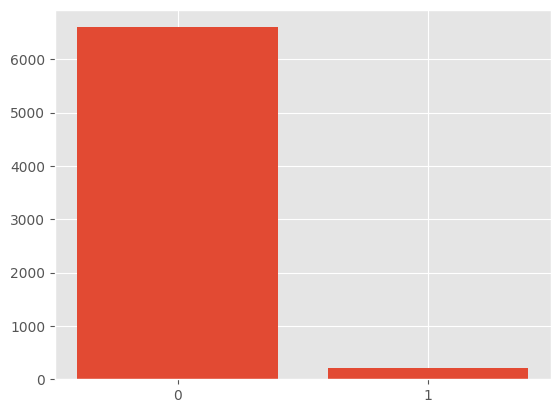

In [ ]:
counts = df['Bankrupt?'].value_counts()
plt.bar(counts.index, counts.values)
plt.xticks([0, 1])
plt.show()

In [ ]:
df.iloc[:,94].unique() # Net income flag

array([1])

In [ ]:
df = df.drop(columns=[' Net Income Flag'])

In [ ]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
corr = df.select_dtypes(include=numerics).corr()
corr.style.background_gradient(cmap='coolwarm')

In [ ]:
scaler = MinMaxScaler()
df.iloc[:,:] = scaler.fit_transform(df)

In [ ]:
X, Y = df.iloc[:,1:].values, df.iloc[:,0].values
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

In [ ]:
print("Training distribution:", Counter(y_train))
print("Test distribution:", Counter(y_test))
print("Original distribution:", Counter(Y))

Training distribution: Counter({0: 4619, 1: 154})
Test distribution: Counter({0: 1980, 1: 66})
Original distribution: Counter({0: 6599, 1: 220})


In [ ]:
def acc_prec(y_test, y_predict):
    total = len(y_predict)
    correct = 0

    true_positive = 0
    false_positive = 0

    for i in range(total):
        if y_test[i] == y_predict[i]:
            correct += 1

        if y_test[i] == 1 and y_predict[i] == 1:
            true_positive += 1
        if y_test[i] == 0 and y_predict[i] == 1:
            false_positive += 1
    acc = (correct/total) * 100
    prec = (true_positive/(false_positive + true_positive)) * 100 if false_positive + true_positive != 0 else 0
    return acc, prec

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(x_train, y_train)
y_predict = knn_classifier.predict(x_test)

acc, prec = acc_prec(y_test, y_predict)
print('normal acc, prec:', acc, prec)

NameError: name 'acc_prec' is not defined

In [ ]:
# Random Over-Sampler (RO)

ros = RandomOverSampler(random_state=69)
x_train_res, y_train_res = ros.fit_resample(x_train, y_train)

print('Resampled dataset shape %s' % Counter(y_train_res))

knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(x_train_res, y_train_res)
y_predict     = knn_classifier.predict(x_test)

acc, prec = acc_prec(y_test, y_predict)
print('normal acc, prec:', acc, prec)


Resampled dataset shape Counter({0: 4619, 1: 4619})
normal acc, prec: 93.10850439882698 19.51219512195122


In [ ]:
# SMOTE
sm = SMOTE(random_state=69)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train_res))

knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(x_train_res, y_train_res)
y_predict     = knn_classifier.predict(x_test)

acc, prec = acc_prec(y_test, y_predict)
print('normal acc, prec:', acc, prec)

Resampled dataset shape Counter({0: 4619, 1: 4619})
normal acc, prec: 89.05180840664711 15.948275862068966


In [ ]:
# K-Folds
kf = KFold(n_splits=5)

knn_classifier = KNeighborsClassifier(n_neighbors=5)
for train_index, test_index in kf.split(x_train):
    x_kfold_train, x_kfold_test = x_train[train_index], x_train[test_index]
    y_kfold_train, y_kfold_test = y_train[train_index], y_train[test_index]

    knn_classifier.fit(x_kfold_train, y_kfold_train)

y_predict = knn_classifier.predict(x_test)
acc, prec = acc_prec(y_test, y_predict)
print('normal acc, prec:', acc, prec)


normal acc, prec: 96.43206256109482 18.181818181818183


In [ ]:
################################################################# TEMP #################################################################
################################################################# TEMP #################################################################
################################################################# TEMP #################################################################
################################################################# TEMP #################################################################
################################################################# TEMP #################################################################
################################################################# TEMP #################################################################
def eval_model(model):
    y_predict = model.predict(x_test)
    total = len(y_predict)
    correct = 0

    TP = FP = FN = TN = 0
    for actual, predicted in zip(y_test, y_predict):
        if actual == predicted:
            correct += 1

        if actual == 1 and predicted == 1:
            TP += 1  # True positive
        elif actual == 0 and predicted == 1:
            FP += 1  # False positive
        elif actual == 1 and predicted == 0:
            FN += 1  # False negative
        elif actual == 0 and predicted == 0:
            TN += 1  # True negative


    accuracy = (correct/total)
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    return accuracy, precision, recall, f1_score


knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(x_train, y_train)
print('normal    ', eval_model(knn_classifier))

ros = RandomOverSampler(random_state=69)
x_train_res, y_train_res = ros.fit_resample(x_train, y_train)
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(x_train_res, y_train_res)
print('Random Oversampler', eval_model(knn_classifier))

sm = SMOTE(random_state=69)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(x_train_res, y_train_res)
print('SMOTE       ', eval_model(knn_classifier))


kf = KFold(n_splits=5)
knn_classifier = KNeighborsClassifier(n_neighbors=5)
for train_index, test_index in kf.split(x_train):
    x_kfold_train, x_kfold_test = x_train[train_index], x_train[test_index]
    y_kfold_train, y_kfold_test = y_train[train_index], y_train[test_index]
    knn_classifier.fit(x_kfold_train, y_kfold_train)
print('KFold     ', eval_model(knn_classifier))
################################################################# TEMP #################################################################
################################################################# TEMP #################################################################
################################################################# TEMP #################################################################
################################################################# TEMP #################################################################
################################################################# TEMP #################################################################
################################################################# TEMP #################################################################
################################################################# TEMP #################################################################
################################################################# TEMP #################################################################
################################################################# TEMP #################################################################

normal     (0.9652981427174976, 0.2727272727272727, 0.045454545454545456, 0.07792207792207792)
Random Oversampler (0.9310850439882697, 0.1951219512195122, 0.36363636363636365, 0.25396825396825395)
SMOTE        (0.8905180840664711, 0.15948275862068967, 0.5606060606060606, 0.24832214765100669)
KFold      (0.9643206256109482, 0.18181818181818182, 0.030303030303030304, 0.05194805194805195)


In [ ]:
NORMAL_METHOD = 'Normal'

RANDOM_OVERSAMPLER_METHOD = 'Random Over-Sampler'
ros = RandomOverSampler(random_state=69)
x_train_random_oversampler, y_train_random_oversampler = ros.fit_resample(x_train, y_train)

SMOTE_METHOD  = 'SMOTE'
sm = SMOTE(random_state=69)
x_train_smote, y_train_smote = sm.fit_resample(x_train, y_train)

KFOLDS_METHOD = 'K-Folds cross validation'
kf = KFold(n_splits=5)

def train_model(model, training_method):
    if training_method == NORMAL_METHOD:
        model.fit(x_train, y_train)

    elif training_method == RANDOM_OVERSAMPLER_METHOD:
        model.fit(x_train_random_oversampler, y_train_random_oversampler)

    elif training_method == SMOTE_METHOD:
        model.fit(x_train_smote, y_train_smote)

    elif training_method == KFOLDS_METHOD:
        for train_index, test_index in kf.split(x_train):
            x_kfold_train, x_kfold_test = x_train[train_index], x_train[test_index]
            y_kfold_train, y_kfold_test = y_train[train_index], y_train[test_index]

            model.fit(x_kfold_train, y_kfold_train)
    else:
        assert(not 'Invalid training method')

    return model

def eval_model(model):
    y_predict = model.predict(x_test)
    total = len(y_predict)
    correct = 0

    TP = FP = FN = TN = 0
    for actual, predicted in zip(y_test, y_predict):
        if actual == predicted:
            correct += 1

        if actual == 1 and predicted == 1:
            TP += 1  # True positive
        elif actual == 0 and predicted == 1:
            FP += 1  # False positive
        elif actual == 1 and predicted == 0:
            FN += 1  # False negative
        elif actual == 0 and predicted == 0:
            TN += 1  # True negative


    accuracy = (correct/total)
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    return accuracy, precision, recall, f1_score

In [ ]:
%%capture
models = [LogisticRegression,
          LinearDiscriminantAnalysis,
          GaussianNB,
          SVC,
          KNeighborsClassifier,
          DecisionTreeClassifier,
          RandomForestClassifier,
          GradientBoostingClassifier,
          AdaBoostClassifier,
          HistGradientBoostingClassifier,
          LGBMClassifier,
          CatBoostClassifier,
          XGBClassifier,
]

training_methods = [
    NORMAL_METHOD,
    RANDOM_OVERSAMPLER_METHOD,
    SMOTE_METHOD,
    KFOLDS_METHOD,
]

stats = {}
for ModelClass in models:
    stats[ModelClass.__name__] = {}
    for training_method in training_methods:
        model = ModelClass()
        model = train_model(model, training_method)
        accuracy, precision, recall, f1_score = eval_model(model)
        stats[ModelClass.__name__][training_method] = (accuracy, precision, recall, f1_score)

In [ ]:
best_f1 = 0
best_model = 0
best_method = 0
for m, mm in stats.items():
    print(m)
    for mmm, mmmm in mm.items():
        f1 = mmmm[3]
        if f1 > best_f1:
            best_f1 = f1
            best_model = m
            best_method = mmm
        print(f'\t{mmm:<25}{f1}')
print(best_model, best_method, best_f1)

LogisticRegression
	Normal                   0.15789473684210525
	Random Over-Sampler      0.2986666666666667
	SMOTE                    0.2981029810298103
	K-Folds cross validation 0.15789473684210525
LinearDiscriminantAnalysis
	Normal                   0.33870967741935487
	Random Over-Sampler      0.2874251497005988
	SMOTE                    0.29411764705882354
	K-Folds cross validation 0.32786885245901637
GaussianNB
	Normal                   0.08676140613313388
	Random Over-Sampler      0.08146067415730338
	SMOTE                    0.08327246165084003
	K-Folds cross validation 0.09652836579170194
SVC
	Normal                   0
	Random Over-Sampler      0.2887700534759358
	SMOTE                    0.2994011976047904
	K-Folds cross validation 0
KNeighborsClassifier
	Normal                   0.07792207792207792
	Random Over-Sampler      0.25396825396825395
	SMOTE                    0.24832214765100669
	K-Folds cross validation 0.05194805194805195
DecisionTreeClassifier
	Normal         

In [ ]:
def tune_params(trial):
    learning_rate    = trial.suggest_float('learning_rate', 0, 1)     # 0.1
    max_iter         = trial.suggest_int('max_iter', 1, 300)        # 100
    max_leaf_nodes   = trial.suggest_int('max_leaf_nodes', 2, 100)  # 31
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 50) # 20
    warm_start       = trial.suggest_categorical('warm_start', [True, False]) # False
    n_iter_no_change = trial.suggest_int('n_iter_no_change', 1, 30) # 10

    model = HistGradientBoostingClassifier(learning_rate=learning_rate,
                                           max_iter=max_iter,
                                           max_leaf_nodes=max_leaf_nodes,
                                           min_samples_leaf=min_samples_leaf,
                                           warm_start=warm_start,
                                           n_iter_no_change=n_iter_no_change)
    model = train_model(model, RANDOM_OVERSAMPLER_METHOD)
    accuracy, precision, recall, f1_score = eval_model(model)
    return f1_score

study = optuna.create_study(direction="maximize")
study.optimize(tune_params, n_trials=50, show_progress_bar=True)

print("Best trial:")
best_trial = study.best_trial
print(f"  F1: {best_trial.value}")
print(f"  Best hyperparameters: {best_trial.params}")

  0%|          | 0/50 [00:00<?, ?it/s]

Best trial:
  F1: 0.5420560747663551
  Best hyperparameters: {'learning_rate': 0.9084578238481625, 'max_iter': 254, 'max_leaf_nodes': 40, 'min_samples_leaf': 49, 'warm_start': True, 'n_iter_no_change': 27}


In [ ]:
fig = optuna.visualization.plot_param_importances(study)
show(fig)
fig = optuna.visualization.plot_parallel_coordinate(study)
show(fig)
fig = optuna.visualization.plot_optimization_history(study)
show(fig)

In [ ]:
learning_rate= 0.9084578238481625
max_iter = 254
max_leaf_nodes = 40
min_samples_leaf = 49
warm_start = True
n_iter_no_change = 27

model = HistGradientBoostingClassifier(learning_rate=learning_rate,
                                       max_iter=max_iter,
                                       max_leaf_nodes=max_leaf_nodes,
                                       min_samples_leaf=min_samples_leaf,
                                       warm_start=warm_start,
                                       n_iter_no_change=n_iter_no_change)
model = train_model(model, RANDOM_OVERSAMPLER_METHOD)
accuracy, precision, recall, f1_score = eval_model(model)
print('accuracy: ',  accuracy)
print('precision: ', precision)
print('recall: ',    recall)
print('f1_score: ',  f1_score)

accuracy:  0.9760508308895406
precision:  0.7073170731707317
recall:  0.4393939393939394
f1_score:  0.5420560747663551
